<a id='Table of Contents'></a><h3>Table of Contents</h3>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required librairies</a>  
- <a href='#setting_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the model `delta_lorentz` corresponding to a 
delta representing a fraction $p$ of fixed atoms and a
Lorentzian corresponding to a Brownian Translational
diffusion model for the remaining $(1-p)$ atoms
</div>

The **reference data** were generated using the above function using the following parameters $p = 0.3$ and $D = 0.145$ AA$^2\times$meV.

The model is convoluted with a Gaussian resolution function 
of Full Width Half Maximum (FWHM) equal to 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

There is no background.

The data are fitted with a general model of a delta + a
Lorentzian, so the fitted parameters are not $p$ and $D$, but
$p$ and a $Q$-dependent HWHM.

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
!{sys.executable} -m pip install bumps

sasview 4.0 requires lxml, which is not installed.
sasview 4.0 requires periodictable>=1.3.1, which is not installed.
sasview 4.0 requires pillow, which is not installed.
sasview 4.0 has requirement pyparsing<2.0.0, but you'll have pyparsing 2.2.0 which is incompatible.
nglview 1.0 has requirement ipywidgets==7, but you'll have ipywidgets 7.0.3 which is incompatible.


 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

These settings are saved in a Python script, which will be used by Bumps to run the fit.

In [3]:
# Name of Python script containing the model
model_file = "model_fit_DeltaLorentz.py"

In [4]:
%%writefile $model_file
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'DeltaBrownianDiff_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'DeltaBrownianDiff_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   


# Fitting model 
def model_convol(x, q, scale=1, center=0, A0=0, hwhm=1, resolution=None):
    model = QENSmodels.sqwDeltaLorentz(x, q, scale, center, A0, hwhm)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, A0=0.5, hwhm=0.01, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.A0.range(0, 1)
    Mq.hwhm.range(0, 2)
    
    # Q-independent parameters
    if i == 0:
       QA0 = Mq.A0  
    else:
       Mq.A0 = QA0
    M.append(Mq)
        
problem = FitProblem(M)

Overwriting model_fit_DeltaLorentz.py


<h3> Choice of minimizer for bumps </h3>

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description=u'Minimizer:', index=4, options={'Quasi-Newton BFGS': 'newton', 'Random Lines (experimental)': 'rl', 'Parallel Tempering (experimental)': 'pt', 'Particle Swarm (experimental)': 'ps', 'Levenberg-Marquardt': 'lm', 'Differential Evolution': 'de', 'Nelder-Mead Simplex': 'amoeba', 'DREAM': 'dream'}, value='lm')

<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

# output folder to save thre results
output_folder = 'QENS'

(<a href='#Table of Contents'>Top</a>)<a id='running_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above
The subfolder *output_folder* contains different results: plots and 
refined parameters

# /Users/celinedurniak/anaconda/envs/aseenv/lib/python2.7/site-packages/bumps/cli.py model_fit_DeltaLorentz.py --fit=lm --steps=100 --store=QENS
-- Model 0 
.A0 = Parameter(0.5, name='A0', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm = Parameter(0.01, name='hwhm', bounds=(0,2))
.q = Parameter(0.2, name='q')
.scale = Parameter(1000, name='scale', bounds=(0,100000))

[chisq=1742.022(12), nllf=349275]
-- Model 1 
.A0 = Parameter(0.5, name='A0', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm = Parameter(0.01, name='hwhm', bounds=(0,2))
.q = Parameter(0.4, name='q')
.scale = Parameter(1000, name='scale', bounds=(0,100000))

[chisq=1484.956(12), nllf=297734]
-- Model 2 
.A0 = Parameter(0.5, name='A0', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm = Parameter(0.01, name='hwhm', bounds=(0,2))
.q = Parameter(0.6, name='q')
.scale = Parameter(1000, name='scale', bounds=(0,100000))

[chisq=1394.374(12), n

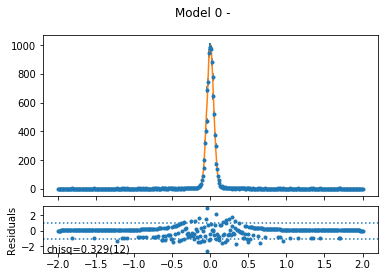

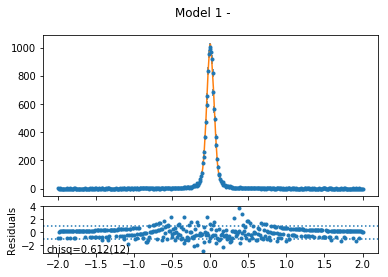

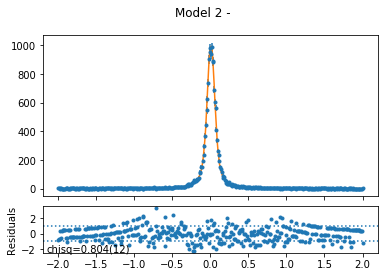

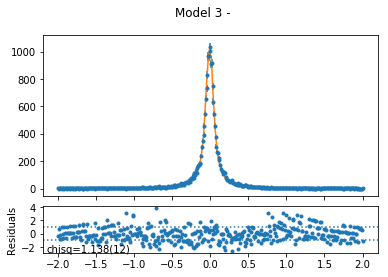

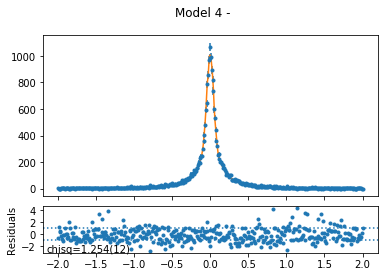

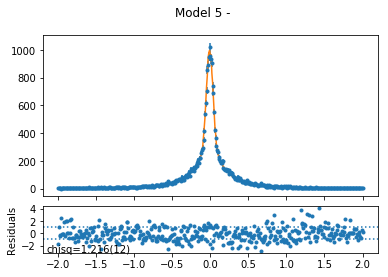

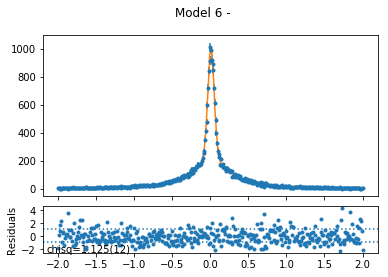

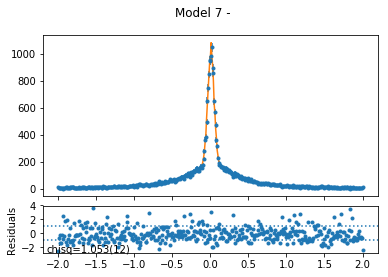

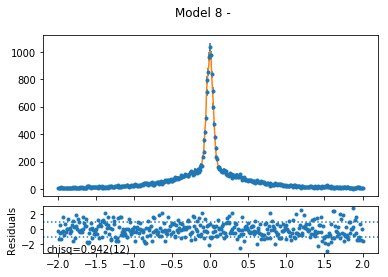

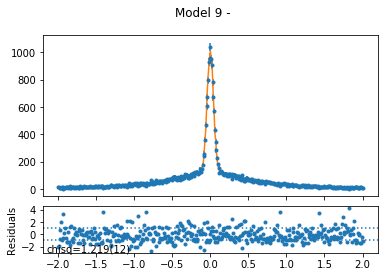

In [7]:
%run -m bumps.cli $model_file --fit=$minimiser --steps=$steps --store=$output_folder

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

In [8]:
# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'
err_file = os.path.splitext(model_file)[0] + '.err'

with open(os.path.join('.', output_folder, par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print(parameter, value)
        
with open(os.path.join(os.getcwd(), output_folder, err_file), 'r') as ferr:
    for line in ferr:
        print(line.rsplit('\n')[0])

A0 0.302250839522119
center 0.00199335993287508
hwhm 0.00527644430492817
scale 111.056672085575
center -0.000566875677758475
hwhm 0.0208132040106282
scale 135.403291538573
center -0.00101462239122815
hwhm 0.0485817863184444
scale 166.098440837863
center -0.00226651001181976
hwhm 0.0853304657017245
scale 200.405878445904
center -0.00128222651344569
hwhm 0.137034695823312
scale 233.514245697494
center -0.00163567512673166
hwhm 0.191893723031897
scale 256.506063536781
center -0.00189493699972805
hwhm 0.268677879831171
scale 271.5343039589
center 0.00499955468415395
hwhm 0.362967587338635
scale 292.125040255414
center -0.00335955411129431
hwhm 0.447671081526578
scale 297.809634799262
center -0.00122222913061469
hwhm 0.552733569608868
scale 308.971334363557
-- Model 0 
.A0 = Parameter(0.302251, name='A0', bounds=(0,1))
.center = Parameter(0.00199336, name='center', bounds=(-0.1,0.1))
.hwhm = Parameter(0.00527644, name='hwhm', bounds=(0,2))
.q = Parameter(0.2, name='q')
.scale = Parameter(11

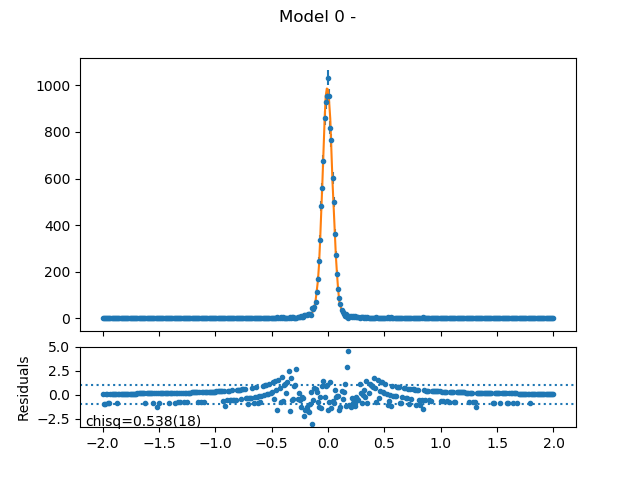

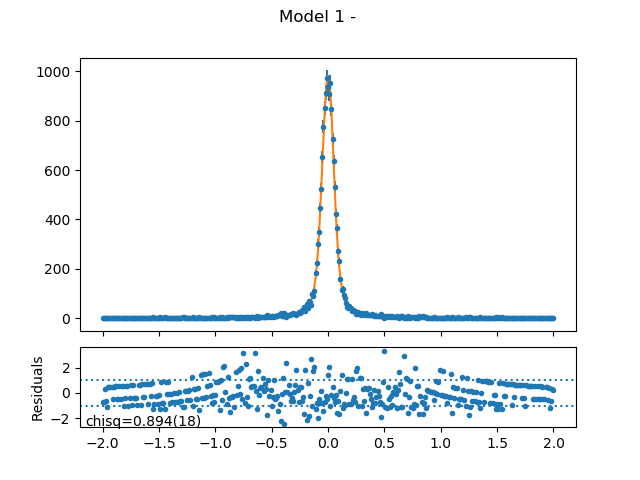

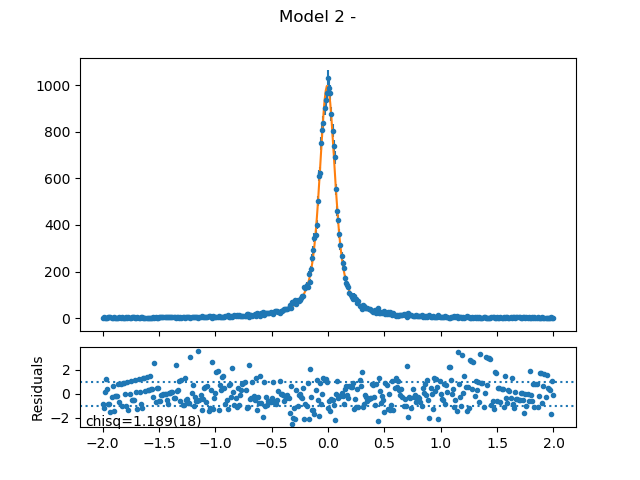

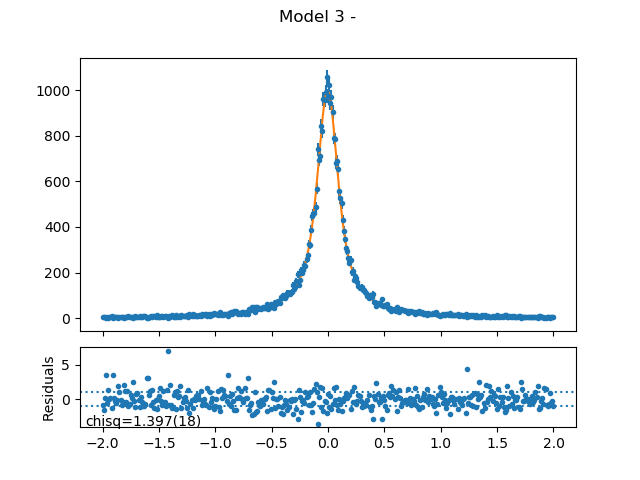

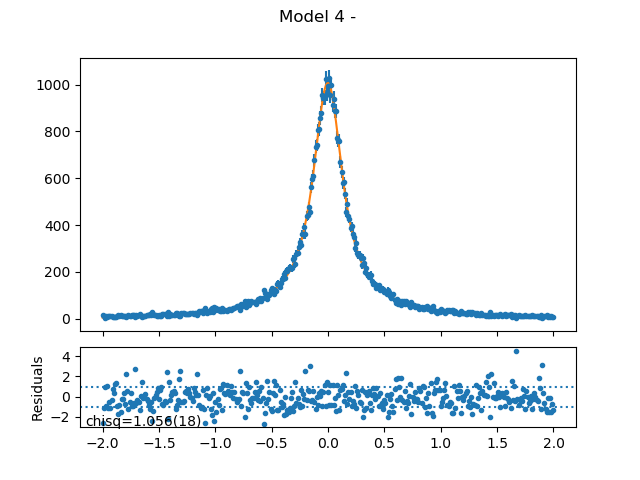

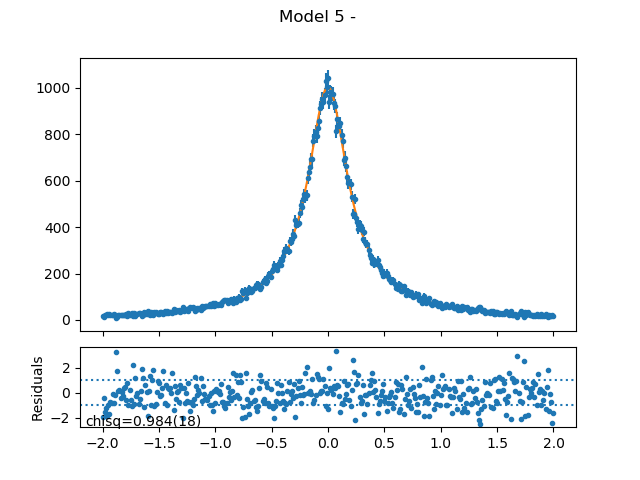

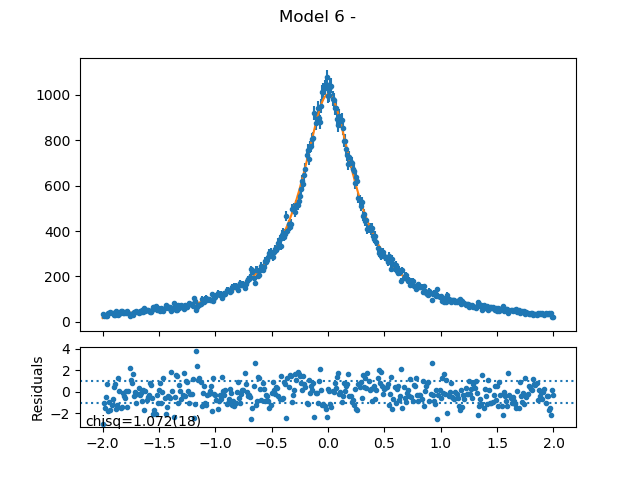

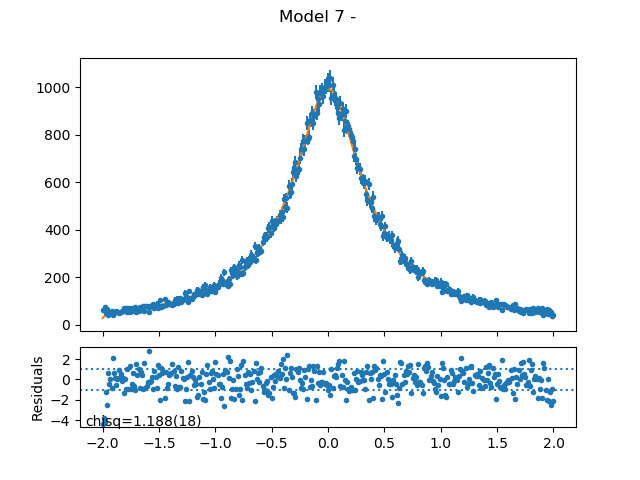

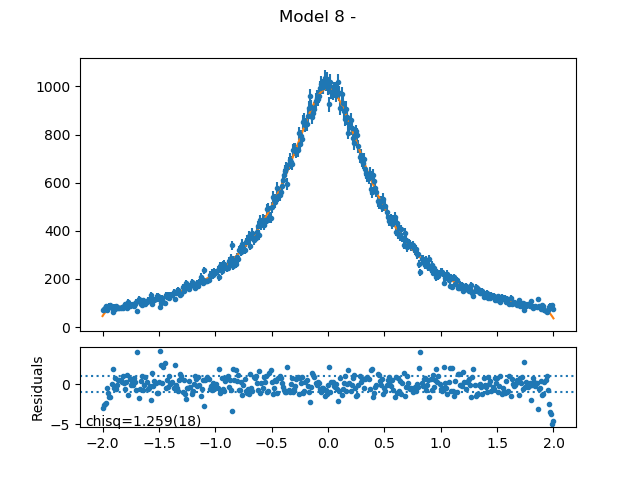

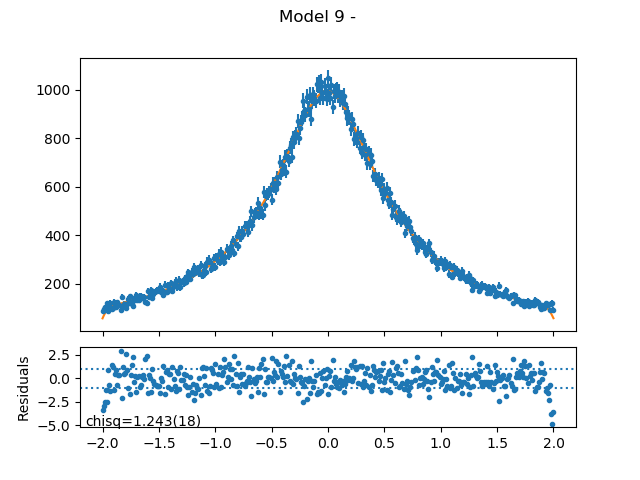

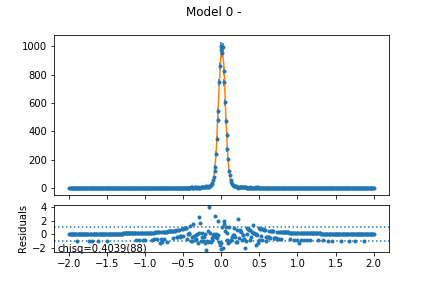

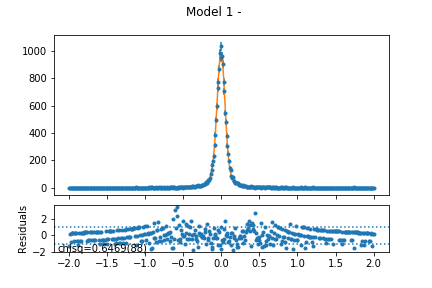

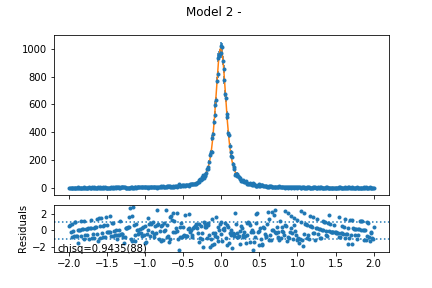

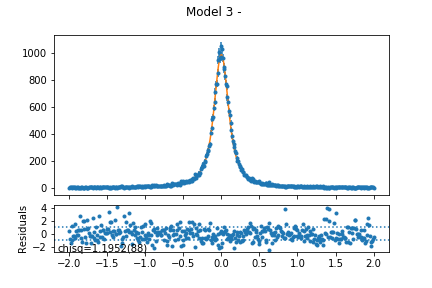

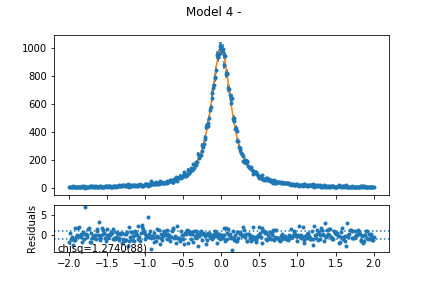

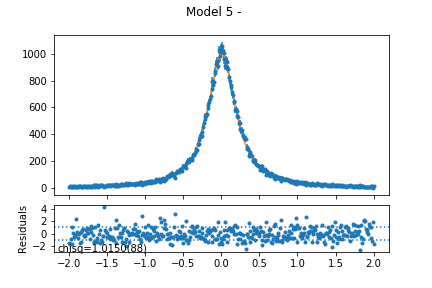

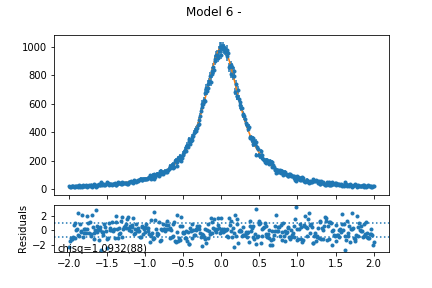

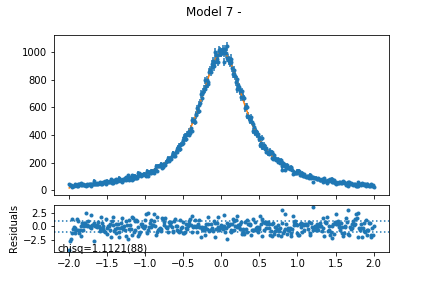

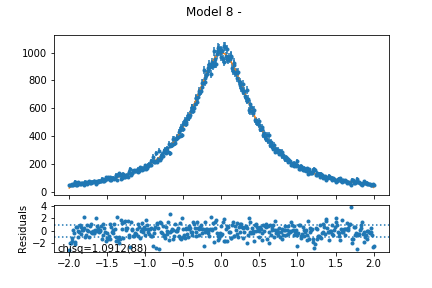

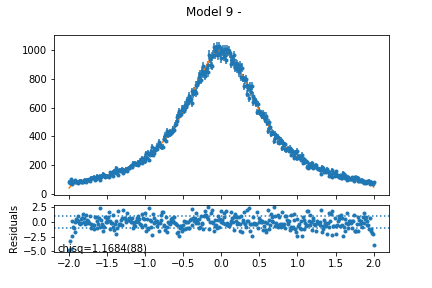

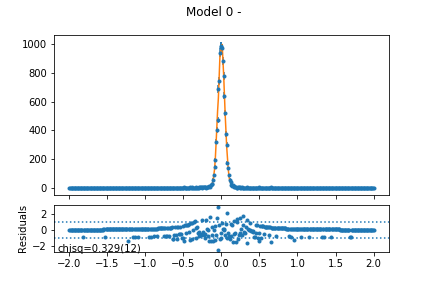

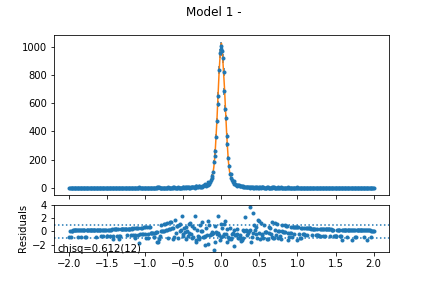

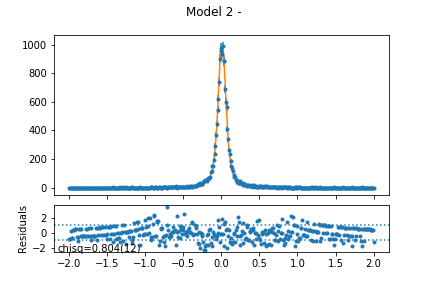

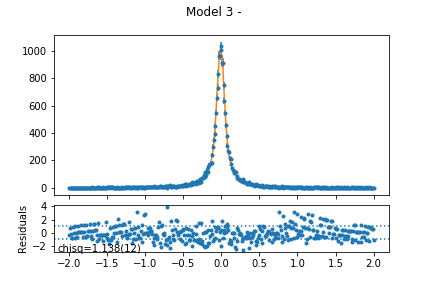

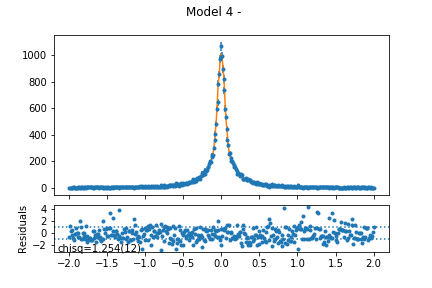

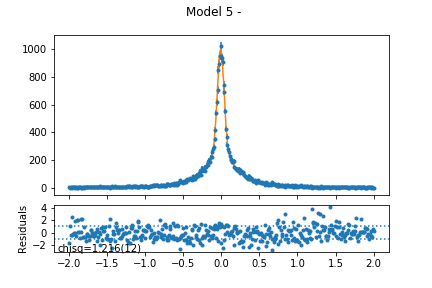

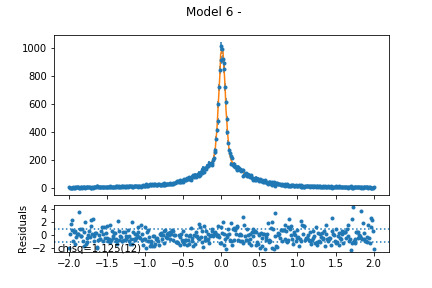

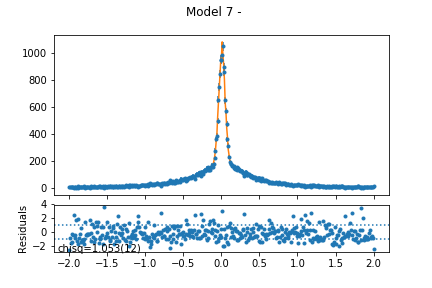

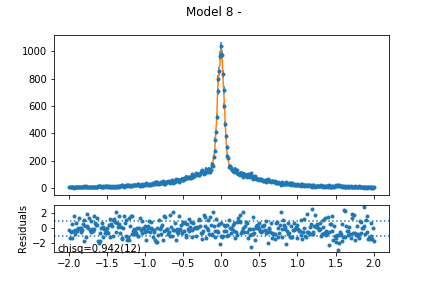

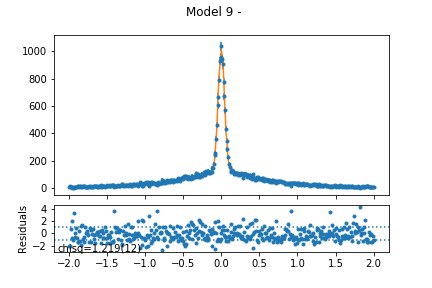

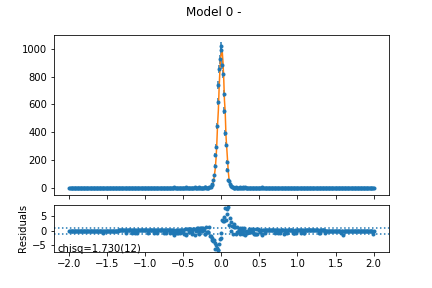

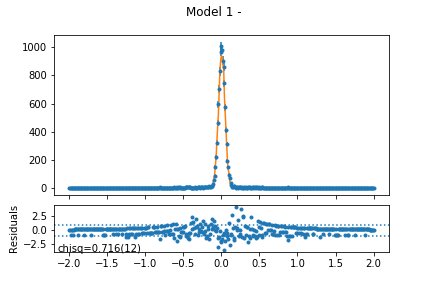

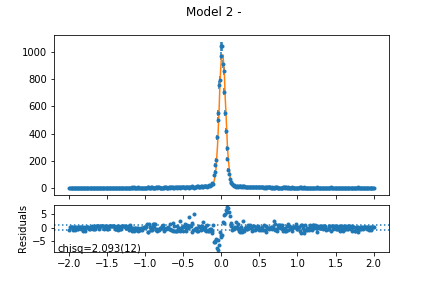

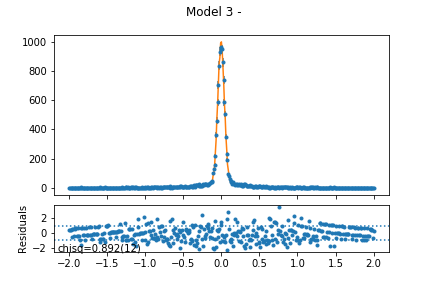

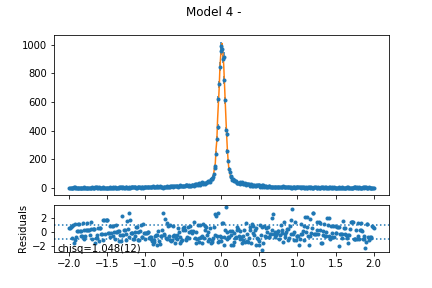

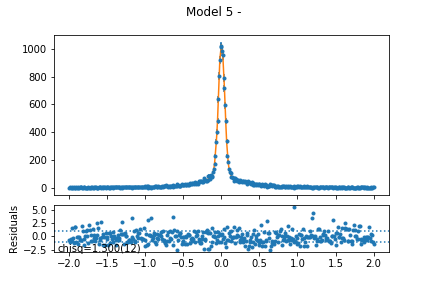

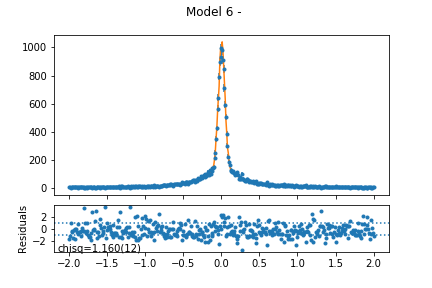

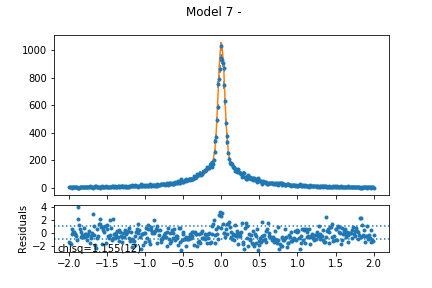

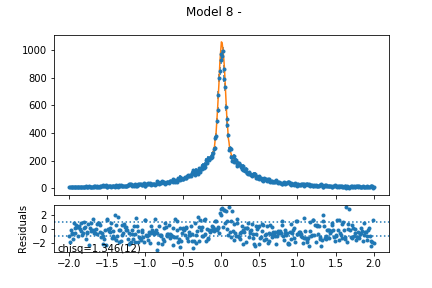

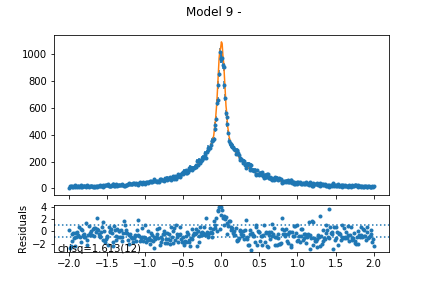

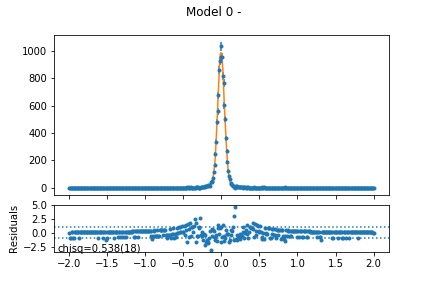

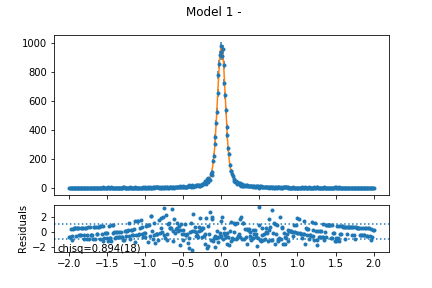

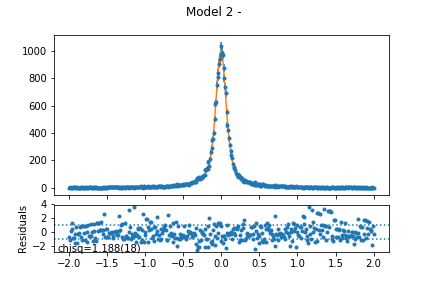

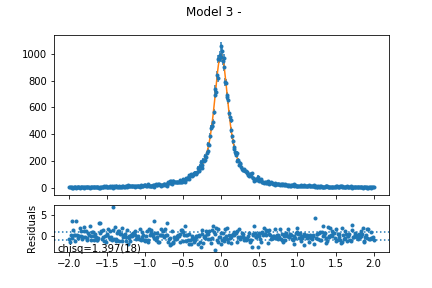

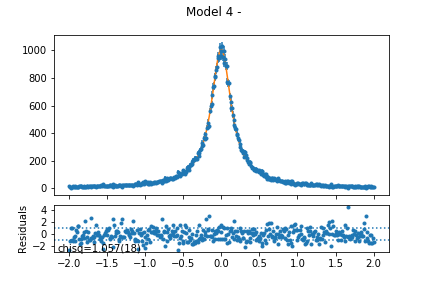

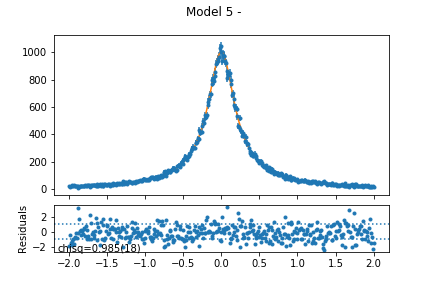

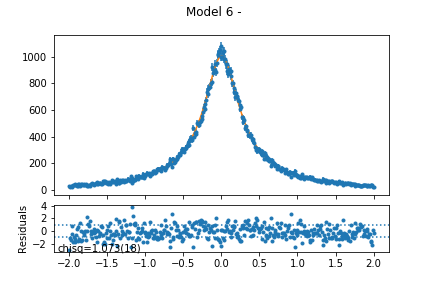

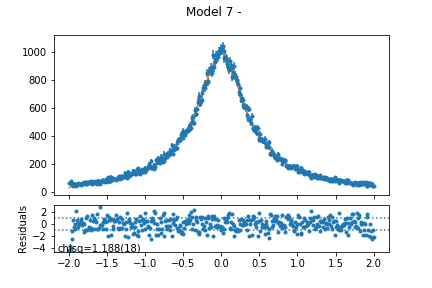

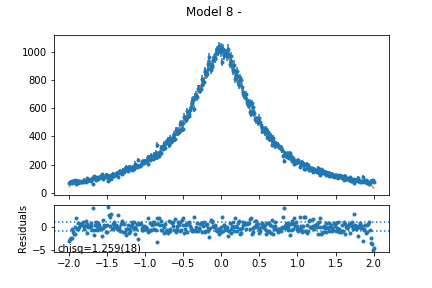

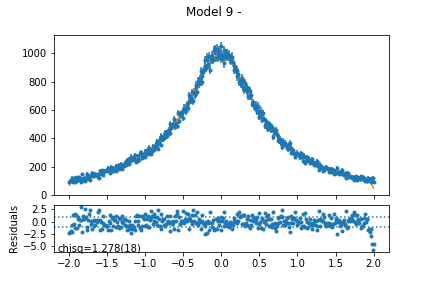

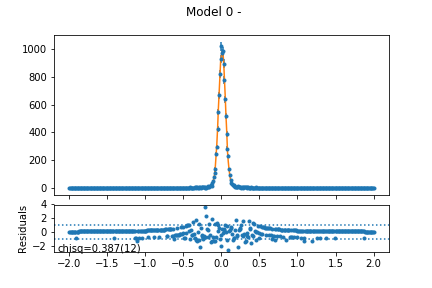

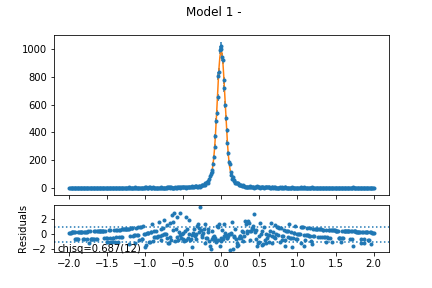

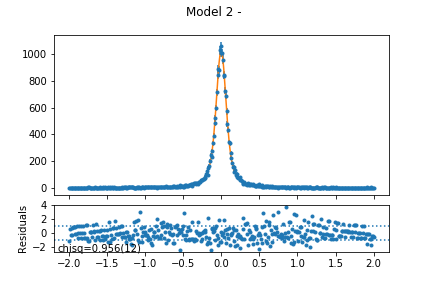

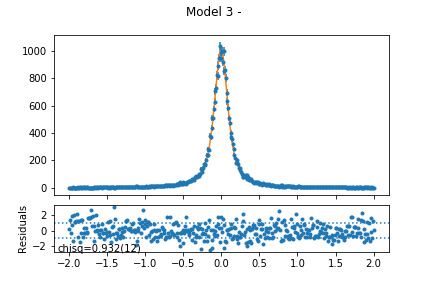

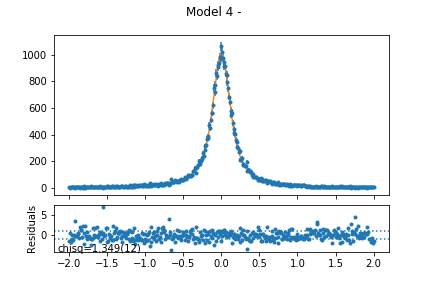

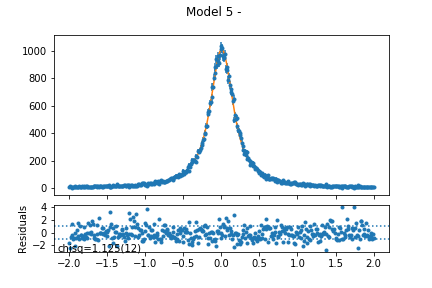

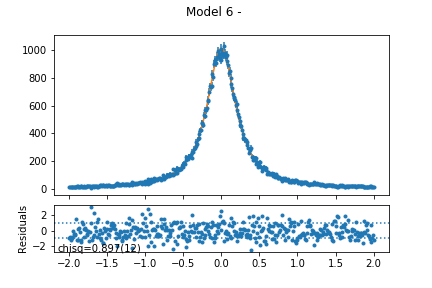

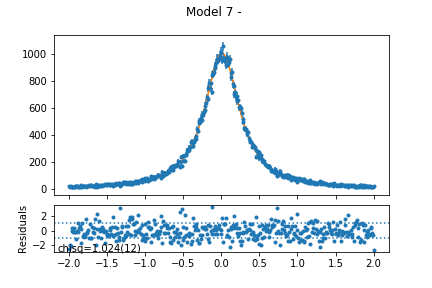

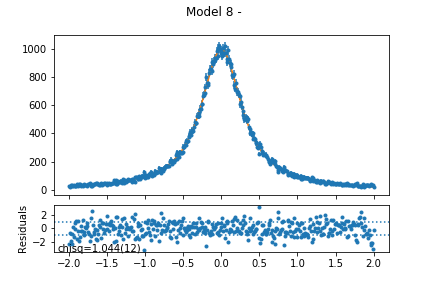

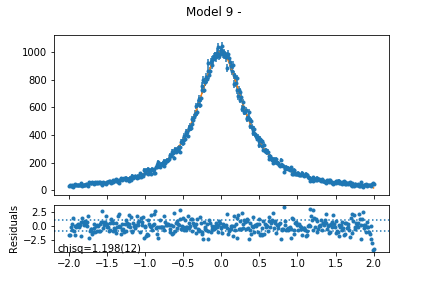

In [9]:
# Plot the fitting results

from IPython.display import display, Image
relative_output_path = os.path.join('.', output_folder)
names = [f for f in os.listdir(relative_output_path) if f.endswith('.png')]

for name in names:
    display(Image(os.path.join(relative_output_path, name)))